# Cassava Leaf Disease Classification
> Identify the type of disease present on Cassava Leaf image

- toc: true
- badges: true
- categories: [plant,disease,classification,efficientnet]


This notebook is a simple training pipeline in TensorFlow for the [Cassava Leaf Competition](https://www.kaggle.com/c/cassava-leaf-disease-classification) where we are given `21,397` labeled images of cassava leaves classified as 5 different groups (4 diseases and a healthy group) and asked to predict on unseen images of cassava leaves. As with most image classification problems, we can use and experiment with many different forms of augmentation and we can explore transfer learning. 

In [36]:
#hide
%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']

Overwriting conditional_cell_extension.py


In [ ]:
#hide
%reload_ext conditional_cell_extension

> Note:  I am using [Dimitre](https://www.kaggle.com/dimitreoliveira)'s TFRecords that can be found [here](https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tfrecords-512x512). He also has 128x128, 256x256, and 384x384 sized images that I added for experimental purposes. Please give his datasets an upvote (and his work in general, it is excellent).

In [ ]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.0


In [ ]:
#hide
#@title Accelerator type { run: "auto", display-mode: "form" }
DEVICE = 'GPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


> Tip: Adding seed helps reproduce results. Setting debug parameter wil run the model on smaller number of epochs to validate the architecture.

In [ ]:
#hide-collapse
#@title Notebook type { run: "auto", display-mode:"form" }
SEED = 16
DEBUG = False #@param {type:"boolean"}
TRAIN = True #@param {type:"boolean"}

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not GOOGLE

seed_everything(SEED)

print("Running on {}!".format(
   "Google Colab" if GOOGLE else "Kaggle Kernel"
))

Running on Google Colab!


In [ ]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#hide
project_name = 'cassava-leaf-disease-classification'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'cassava-leaf-disease-classification.zip',
 'test_images',
 'test_tfrecords',
 'train_images',
 'train_tfrecords',
 'dump.tfcache.data-00000-of-00001',
 'dump.tfcache.index',
 'working']

# Hyperparameters

In [ ]:
#hide-collapse
#@title {run: "auto", display-mode: "form" }

BASE_MODEL= 'efficientnet_b3' #@param ["'efficientnet_b3'", "'efficientnet_b4'", "'efficientnet_b2'"] {type:"raw", allow-input: true}
BATCH_SIZE = 32 #@param {type:"integer"}
HEIGHT = 300#@param {type:"number"}
WIDTH = 300#@param {type:"number"}
CHANNELS = 3#@param {type:"number"}
IMG_SIZE = (HEIGHT, WIDTH, CHANNELS)
EPOCHS =  8#@param {type:"number"}
print("Using {} with input size {}".format(BASE_MODEL, IMG_SIZE))

Using efficientnet_b3 with input size (300, 300, 3)


# Data

## Exploring data

In [ ]:
df = pd.read_csv(f'{input_path}train.csv')
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Check how many images are available in the training dataset and also check if each item in the training set are unique

In [ ]:
#collapse-hide
print(f"Number of training images: {len(df)}")
len(df.image_id) == len(df.image_id.unique())

Number of training images: 21397


True

The distribution of labels is obviously unbalanced as can be observed in the figure below.

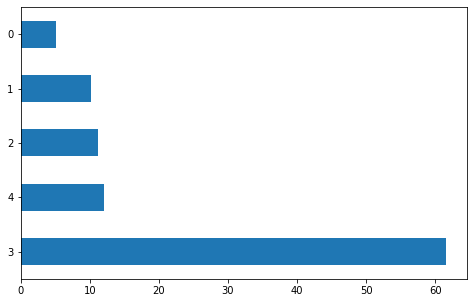

In [ ]:
#collapse-hide
(df.label.value_counts(normalize=True) * 100).plot.barh(figsize = (8, 5))

Let's preprocess to add the directory string to the filename and rename the column to `filename`

In [ ]:
df['filename'] = df['image_id'].map(lambda x : f'{input_path}train_images/{x}')
df = df.drop(columns = ['image_id'])
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

label                                           filename
0      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
1      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
2      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
3      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...
4      3  /content/gdrive/MyDrive/kaggle/input/cassava-l...

In [ ]:
#hide
%%run_if {DEBUG}
_, df = train_test_split(
    df,
    test_size = 0.1,
    random_state=SEED,
    shuffle=True,
    stratify=df['label'])

Let's find out what labels do we have for the 5 categories.

In [ ]:
#hide_input
with open(f'{input_path}label_num_to_disease_map.json') as file:
    id2label = json.loads(file.read())
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

From the bar chart shown earlier, the label 3, [Cassava Mosaic Disease (CMD)](https://en.wikipedia.org/wiki/Cassava_mosaic_virus) is the most common one. This imbalance may have to be addressed with a weighted loss function or oversampling. I might try this in a future iteration of this kernel or in a new kernel.

Let's check an example image to see what it looks like

In [ ]:
#hide
from PIL import Image
img = Image.open(df[df.label==3]['filename'].iloc[0])

In [ ]:
#hide_input
width, height = img.size
print(f"The size of the image is W{width} x H{height}")

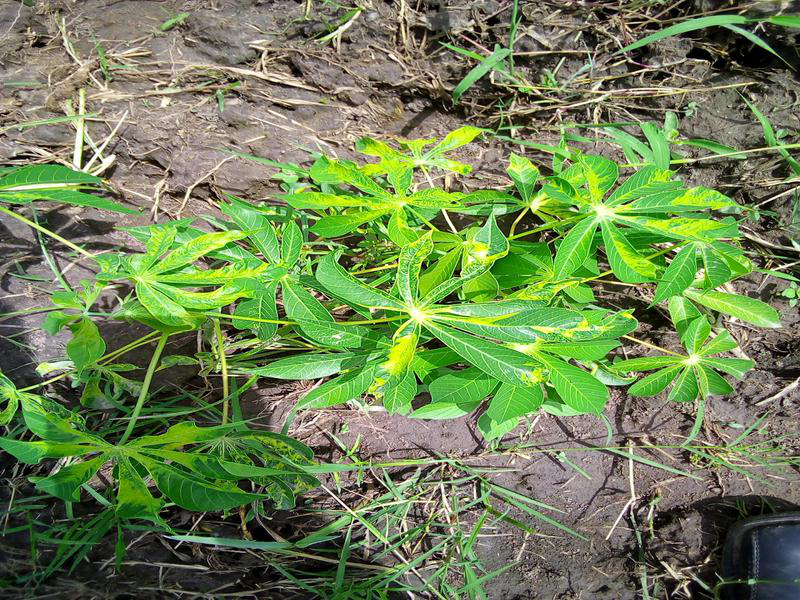

In [37]:
#hide_input
img

## Loading data
After my quick and rough EDA, let's load the PIL Image to a Numpy array, so we can move on to data augmentation.

In fastai, they have `item_tfms` and `batch_tfms` defined for their data loader API. The item transforms performs a fairly large crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.

Split the dataset into training set and validation set

In [38]:
train_df, valid_df = train_test_split(
    df
    ,test_size = 0.2
    ,random_state = SEED
    ,shuffle = True
    ,stratify = df['label'])

In [39]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df.filename.values,train_df.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid_df.filename.values, valid_df.label.values))
adapt_ds = tf.data.Dataset.from_tensor_slices(
    train_df.filename.values)

In [40]:
for x,y in valid_ds.take(3): print(x, y)

tf.Tensor(b'/content/gdrive/MyDrive/kaggle/input/cassava-leaf-disease-classification/train_images/2484271873.jpg', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'/content/gdrive/MyDrive/kaggle/input/cassava-leaf-disease-classification/train_images/3704210007.jpg', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'/content/gdrive/MyDrive/kaggle/input/cassava-leaf-disease-classification/train_images/1655615998.jpg', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)


## Data transformation

In this stage we will collating the data and the label, and then do some basic data transformation so the image size can fit to the input size of the model.

Basically item transformations mainly make sure the input data is of the same size so that it can be collated in batches.


> Important: You may have noticed that I had not used any kind of normalization or rescaling. I recently discovered that there is Normalization layer included in Keras' pretrained EfficientNet, as mentioned [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet). 

In [41]:
#hide-collapse
def decode_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
  
def collate_train(filename, label):
    img = decode_image(filename)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img, seed=None)
    img = tf.image.random_crop(img, IMG_SIZE)
    return img, label

def process_adapt(filename):
    img = decode_image(filename)
    img = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

def collate_valid(filename, label):
    img = decode_image(filename)
    img = tf.image.random_crop(img, IMG_SIZE)
    return img, label

In [42]:
train_ds = train_ds.map(collate_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(collate_valid, num_parallel_calls=AUTOTUNE)
adapt_ds = adapt_ds.map(process_adapt, num_parallel_calls=AUTOTUNE)

In [43]:
train_ds_batch = (train_ds
                  .cache('dump.tfcache')
                  .shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE)
                  .prefetch(buffer_size=AUTOTUNE))

valid_ds_batch = (valid_ds
                  #.shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE*2)
                  .prefetch(buffer_size=AUTOTUNE))

adapt_ds_batch = (adapt_ds
                  .shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE)
                  .prefetch(buffer_size=AUTOTUNE))

In [44]:
#hide-collapse
def show_images(ds):
    _,axs = plt.subplots(3,3,figsize=(16,16))
    for ((x, y), ax) in zip(ds.take(9), axs.flatten()):
        ax.imshow(x.numpy().astype(np.uint8))
        ax.set_title(np.argmax(y))
        ax.axis('off')

Show some training images

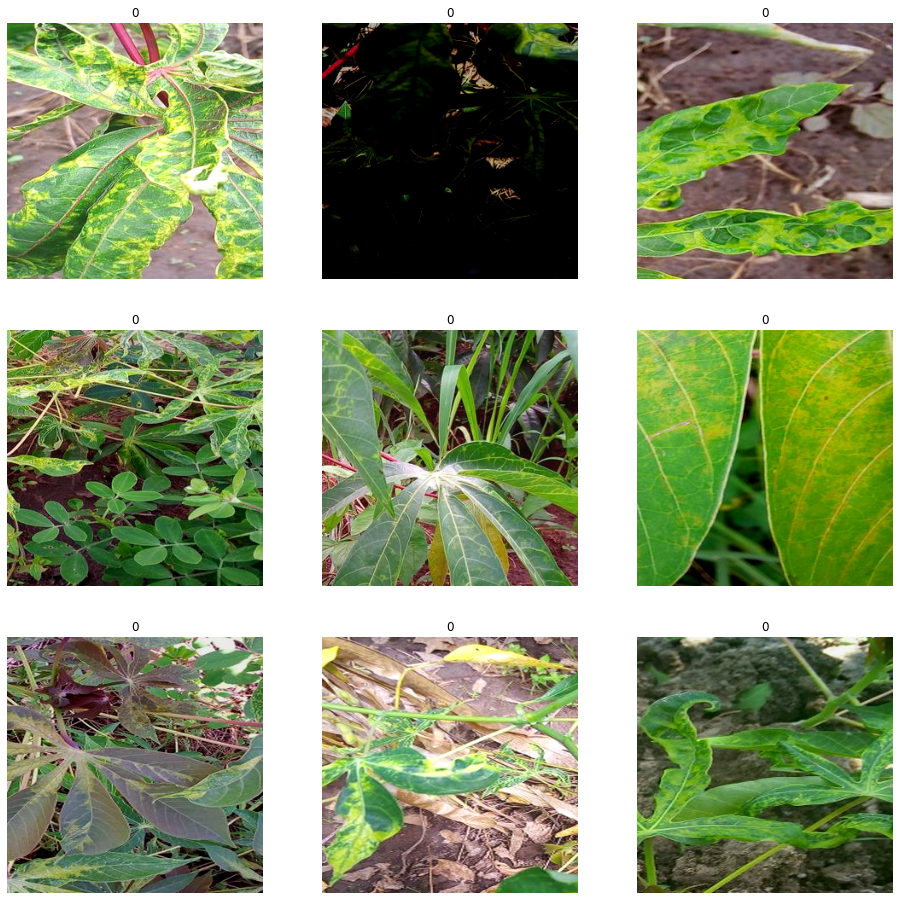

In [45]:
#hide_input
show_images(train_ds)

Show some validation images

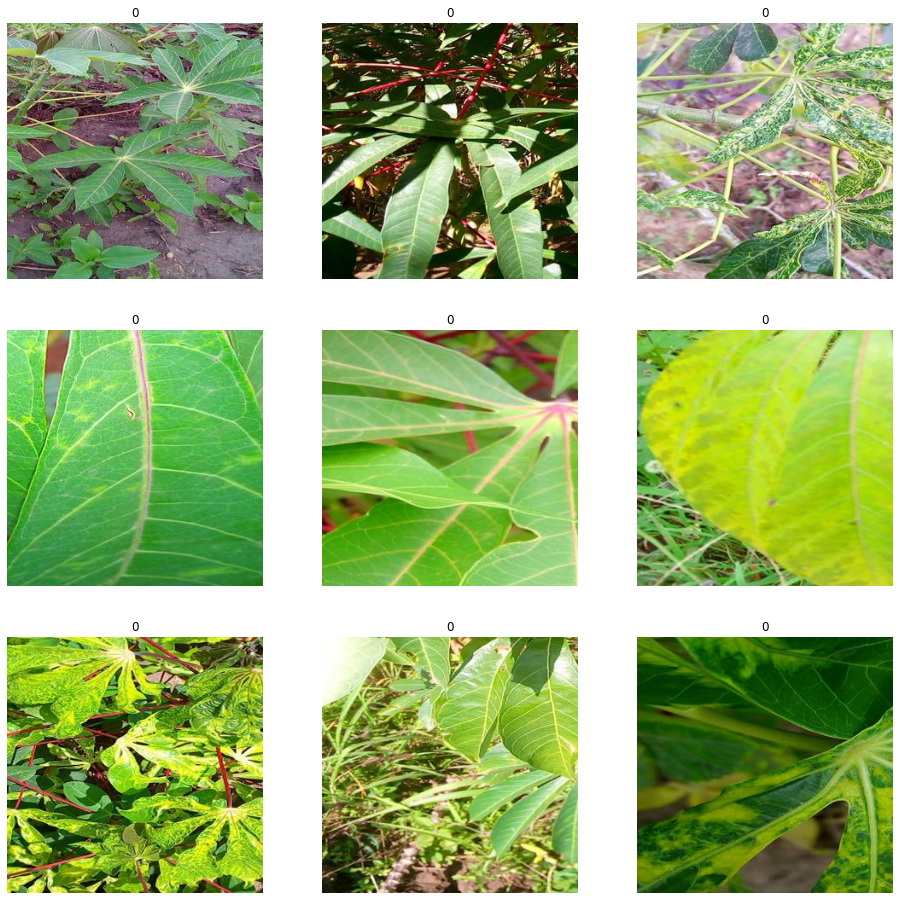

In [46]:
#hide_input
show_images(valid_ds)

# Model



## Batch augmentation

In [47]:
data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomCrop(HEIGHT, WIDTH),
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
     tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
     tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [48]:
func = lambda x,y: (data_augmentation(x), y)
x = (train_ds
     .batch(BATCH_SIZE)
     .take(1)
     .map(func, num_parallel_calls=AUTOTUNE))

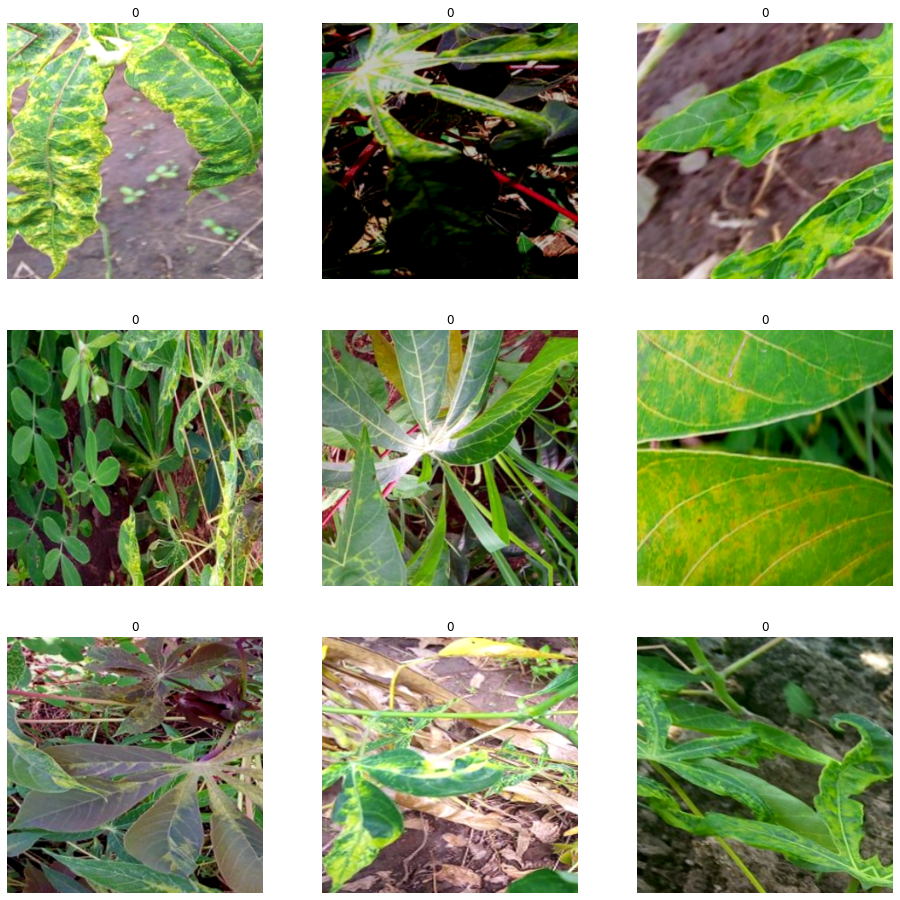

In [49]:
show_images(x.unbatch())

## Building a model

I am using an EfficientNetB3 on top of which I add some output layers to predict our 5 disease classes. I decided to load the imagenet pretrained weights locally to keep the internet off (part of the requirements to submit a kernal to this competition).

In [1]:
#hide
%%run_if {KAGGLE}
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install','-q', '/kaggle/input/kerasapplications'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install','-q', '/kaggle/input/efficientnet-git'])
from efficientnet.tfkeras import EfficientNetB3

UsageError: Cell magic `%%run_if` not found.


In [51]:
%%run_if {GOOGLE}
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import VGG16

In [52]:
def build_model(base_model, num_class):
    inputs = tf.keras.layers.Input(shape=IMG_SIZE)
    x = data_augmentation(inputs)
    x = base_model(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_class, activation="softmax", name="pred")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [53]:
efficientnet = EfficientNetB3(
    weights = 'imagenet' if TRAIN else None, 
    include_top = False, 
    input_shape = IMG_SIZE, 
    pooling='avg')
efficientnet.trainable = True
model = build_model(base_model=efficientnet, num_class=len(id2label))

43941888/43941136 [==============================] - 1s 0us/step


In [54]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
pred (Dense)                 (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_________________________________________________________________


## Fine tune

The 3rd layer of the Efficient is the Normalization layer, which can be tuned to our new dataset instead of `imagenet`. Be patient on this one, it does take a bit of time as we're going through the entire training set.

In [55]:
%%run_if {GOOGLE and TRAIN}
if not os.path.exists("000_normalization.h5"):
    model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_ds_batch)
    model.save_weights("000_normalization.h5")
else:
    model.load_weights("000_normalization.h5")

## Optimizer : CosineDecay

> Important: I always wanted to try the new `CosineDecayRestarts` function implemented in `tf.keras` as it seemed promising and I struggled to find the right settings (if there were any) for the `ReduceLROnPlateau`

8 total epochs and 535 steps per epoch
{'initial_learning_rate': 0.004, 'first_decay_steps': 68, 't_mul': 2.0, 'm_mul': 1, 'alpha': 0.0001, 'name': None}


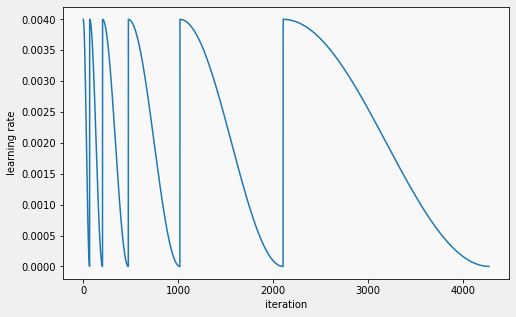

In [57]:
%%run_if {TRAIN}
#@title { run: "auto", display-mode: "form" }
STEPS = math.ceil(len(train_df) / BATCH_SIZE) * EPOCHS
LR_START = 4e-3 #@param {type: "number"}
LR_START *= strategy.num_replicas_in_sync
LR_MIN = 1e-4 #@param {type: "number"}
N_RESTARTS =  5#@param {type: "number"}
T_MUL = 2.0 #@param {type: "number"}
M_MUL =  1#@param {type: "number"}
STEPS_START = math.ceil((T_MUL-1)/(T_MUL**(N_RESTARTS+1)-1) * STEPS)

schedule = tf.keras.experimental.CosineDecayRestarts(
    first_decay_steps=STEPS_START,
    initial_learning_rate=LR_START,
    alpha=LR_MIN,
    m_mul=M_MUL,
    t_mul=T_MUL)

x = [i for i in range(STEPS)]
y = [schedule(s) for s in range(STEPS)]

_,ax = plt.subplots(1,1,figsize=(8,5),facecolor='#F0F0F0')
ax.plot(x, y)
ax.set_facecolor('#F8F8F8')
ax.set_xlabel('iteration')
ax.set_ylabel('learning rate')

print('{:d} total epochs and {:d} steps per epoch'
        .format(EPOCHS, STEPS // EPOCHS))
print(schedule.get_config())

> Warning: There is a gap between what I had expected and the acutal `LearningRateScheduler` that tensorflow gives us. The `LearningRateScheduler` update the lr `on_epoch_begin` while it makes more sense to do it `on_batch_end` or `on_batch_begin`.

## Callbacks

### LR finder

In [61]:
#hide-show
%%run_if {GOOGLE and TRAIN}
from tensorflow.keras.callbacks import Callback
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after
    each training batch between `start_lr` and `end_lr` for a maximum number
    of batches: `max_step`. The loss and learning rate are recorded at each
    step allowing visually finding a good learning rate as
    https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html suggested.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10,
                 max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
%%run_if {GOOGLE and TRAIN}
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
lr_finder = LRFinder()
_ = model.fit(train_ds_batch, epochs=5, callbacks=[lr_finder])

Epoch 1/5
 72/535 [===>..........................] - ETA: 3:25:14 - loss: 1.6262 - accuracy: 0.2442

In [ ]:
%%run_if {GOOGLE and TRAIN}
fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(lr_finder.lrs[:-20], lr_finder.losses[:-20])

In [ ]:
%%run_if {GOOGLE and TRAIN}
efficientnet = EfficientNetB3(
    weights = 'imagenet' if TRAIN else None, 
    include_top = False, 
    input_shape = IMG_SIZE, 
    pooling='avg')
efficientnet.trainable = True
model = build_model(base_model=efficientnet, num_class=len(id2label))
model.load_weights("000_normalization.h5")

### Others

In [ ]:
%%run_if {TRAIN}
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='001_best_model.h5',
        monitor='val_loss',
        save_best_only=True),
    ]

In [ ]:
%%run_if {TRAIN}
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(schedule),
              metrics=["accuracy"])

## Training

In [ ]:
%%run_if {TRAIN}
history = model.fit(train_ds_batch,
                    epochs = EPOCHS,
                    validation_data=valid_ds_batch,
                    callbacks=callbacks)

## Evaluating


In [ ]:
def show_history(history):
    topics = ['loss', 'accuracy']
    groups = [{k:v for (k,v) in history.items() if topic in k} for topic in topics]
    _,axs = plt.subplots(1,2,figsize=(15,6),facecolor='#F0F0F0')
    for topic,group,ax in zip(topics,groups,axs.flatten()):
        for (_,v) in group.items(): ax.plot(v)
        ax.set_facecolor('#F8F8F8')
        ax.set_title(f'{topic} over epochs')
        ax.set_xlabel('epoch')
        ax.set_ylabel(topic)
        ax.legend(['train', 'valid'], loc='best')

In [ ]:
%%run_if {TRAIN}
show_history(history.history)

We load the best weight that were kept from the training phase. Just to check how our model is performing, we will attempt predictions over the validation set. This can help to highlight any classes that will be consistently miscategorised.

In [ ]:
model.load_weights('{}001_best_model.h5'.format(
    '' if TRAIN else '../input/cassava-leaf-disease-classification-models/'))

## Prediction

In [ ]:
x = train_df.sample(1).filename.values[0]
img = decode_image(x)

CPU times: user 61.7 ms, sys: 20 µs, total: 61.7 ms
Wall time: 60.5 ms


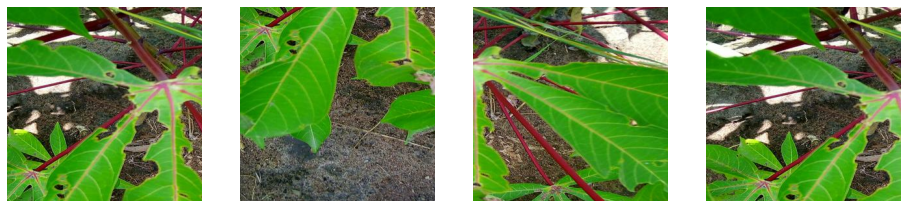

In [ ]:
%%time
imgs = [tf.image.random_crop(img, size=IMG_SIZE) for _ in range(4)]

_,axs = plt.subplots(1,4,figsize=(16,4))
for (x, ax) in zip(imgs, axs.flatten()):
    ax.imshow(x.numpy().astype(np.uint8))
    ax.axis('off')

I apply some very basic test time augmentation to every local image extracted from the original 600-by-800 images. We know we can do some fancy augmentation with `albumentations` but I wanted to do that exclusively with Keras preprocessing layers to keep the cleanest pipeline possible.

In [ ]:
tta = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(HEIGHT, WIDTH),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [ ]:
def predict_tta(filename, num_tta=4):
    img = decode_image(filename)
    img = tf.expand_dims(img, 0)
    imgs = tf.concat([tta(img) for _ in range(num_tta)], 0)
    preds = model.predict(imgs)
    return preds.sum(0).argmax()

In [ ]:
pred = predict_tta(df.sample(1).filename.values[0])
print(pred)

In [ ]:
from tqdm import tqdm
preds = []
with tqdm(total=len(valid_df)) as pbar:
    for filename in valid_df.filename:
        pbar.update()
        preds.append(predict_tta(filename, num_tta=4))

In [ ]:
cm = tf.math.confusion_matrix(valid_df.label.values, np.array(preds))
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            xticklabels=id2label.values(),
            yticklabels=id2label.values(), 
            annot=True,
            fmt='g',
            cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
test_folder = input_path + '/test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] = os.listdir(test_folder)
submission_df["label"] = 0

In [ ]:
submission_df['label'] = (submission_df['image_id']
                            .map(lambda x : predict_tta(test_folder+x)))

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)

# 1% Better Everyday

**reference**
- https://www.kaggle.com/c/cassava-leaf-disease-classification 
- https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-training-with-tpu-v2-pods/notebook#Training-data-samples-(with-augmentation)
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet
- https://www.tensorflow.org/guide/gpu_performance_analysis
- https://www.tensorflow.org/guide/data_performance#prefetching
- https://www.tensorflow.org/guide/data_performance_analysis

---

**todos**
- See if I can integrate the Cutmix/Mixup augmentations in the appendix into our existing notebook. [This](https://www.kaggle.com/tuckerarrants/cassava-tensorflow-starter-training#IV.-Model-Training) is an excellent example
- Still want to figure out some intuition of item aug and batch aug. I don't know, maybe there is some limitation or how to do so to help to speed up.
- Learn more about the `adapt` function that being used to retrain the normalization layer of the EfficientNetB3.

---

**done**
- Predict in batch to speed up
- Add a cell for checkbox parameter to select between kaggle and colab, default is `Kaggle`.
- Try out the `data_generator` and the `data_frame_iterator`
- Removing normalizaiton step in generator since in EfficientNet, normalization is done within the model itself and the model expects input in the range of [0,255]
- Find out the intuition and the difference between `item_tfm` and `batch_tfm`
> In fastai, `item_tfm` defines the transforms that are done on the CPU and `batch_tfm` defines those done on the GPU.

- Customize my own data generator as fastai creates their `Dataloader`
> No need, things are much easier than what I was originally expecting. Please refer to the `Loading data` section in this notebook.

- The 3rd layer of the Efficientnet is the Normalization layer, which can be tuned to our new dataset instead of `imagenet`. Be patient on this one, it does take a bit of time we're going through the entire training set.
- Add `seed_everything` function


